In [2]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from admix.data import quantile_normalize
import seaborn as sns
import admix
import admix_genet_cor
import os

In [2]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-tmp")
trait_list = trait_info["trait"].values

dict_trait_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}

In [49]:
df_assoc = []
for trait in trait_list:
    f_name = f"out/locus-hetero/{trait}.csv"
    if os.path.exists(f_name):
        df_assoc.append(pd.read_csv(f_name, index_col=0))
    else:
        print(f"{f_name} does not exist")
df_assoc = pd.concat(df_assoc).sort_values(["trait", "CHROM", "POS"]).dropna()
df_assoc = df_assoc[
    df_assoc.EUR_af.between(0.005, 0.995) & df_assoc.AFR_af.between(0.005, 0.995)
].reset_index(drop=True)
df_assoc.loc[:, "expected_HET_pval"] = stats.norm.sf(
    quantile_normalize(-df_assoc.HET_pval)
)
df_assoc.loc[:, "bonferroni_significant"] = df_assoc["HET_pval"] < 0.05 / len(df_assoc)

df_assoc["hue"] = ""
df_assoc.loc[df_assoc.bonferroni_significant, "hue"] = df_assoc.loc[
    df_assoc.bonferroni_significant, "trait"
]
df_assoc.loc[~df_assoc.bonferroni_significant, "hue"] = "non-sig"

df_assoc["hue"] = df_assoc["hue"].apply(
    lambda x: dict_trait_name[x] if x in dict_trait_name else x
)
df_assoc = df_assoc[df_assoc["assoc_pval"] < 5e-8]
# df_assoc = df_assoc[~df_assoc.trait.isin(["mean_cell_hgb", "mean_corp_vol"])]

out/locus-hetero/neutrophil.csv does not exist
out/locus-hetero/total_wbc_cnt.csv does not exist


Text(0.5, 1.0, "Pearson's R=0.58")

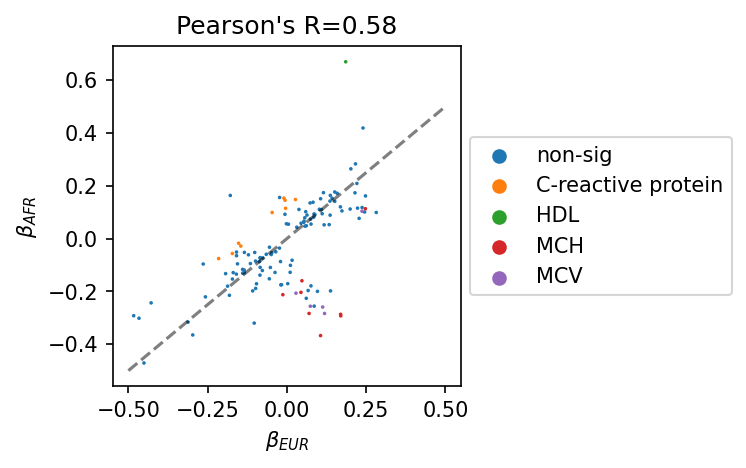

In [50]:
fig, ax = plt.subplots(dpi=150, figsize=(3, 3))
sns.scatterplot(
    data=df_assoc, x="EUR_beta", y="AFR_beta", hue="hue", linewidth=0, s=3, ax=ax
)
ax.plot([-0.5, 0.5], [-0.5, 0.5], color="black", alpha=0.5, ls="--")
ax.legend(loc="center", bbox_to_anchor=[1.4, 0.5])
ax.set_xlabel("$\\beta_{EUR}$")
ax.set_ylabel("$\\beta_{AFR}$")
ax.set_title(
    f"Pearson's R={stats.pearsonr(df_assoc.EUR_beta, df_assoc.AFR_beta)[0]:.2g}"
)

In [51]:
bootstrap_slope_list = []
for _ in range(99):
    df_tmp = df_assoc.sample(len(df_assoc), replace=True)
    slope = admix_genet_cor.locus.deming_regression(
        x=df_tmp["EUR_beta"],
        y=df_tmp["AFR_beta"],
        sx=df_tmp["EUR_beta_stderr"],
        sy=df_tmp["AFR_beta_stderr"],
    )[0]
    bootstrap_slope_list.append(slope)

slope = admix_genet_cor.locus.deming_regression(
    x=df_assoc["EUR_beta"],
    y=df_assoc["AFR_beta"],
    sx=df_assoc["EUR_beta_stderr"],
    sy=df_assoc["AFR_beta_stderr"],
)[0]
print(f"Deming regression slope: {slope}")
print(
    f"Bootstrap mean (se): {np.mean(bootstrap_slope_list):.2f} ({np.std(bootstrap_slope_list):.2f})"
)

Deming regression slope: 1.1601984461824242
Bootstrap mean (se): 1.17 (0.09)


In [53]:
df_assoc[df_assoc.trait == "mean_cell_hgb"]

,trait,CHROM,SNP,POS,EUR_af,AFR_af,assoc_pval,HET_pval,EUR_beta,AFR_beta,EUR_beta_stderr,AFR_beta_stderr,expected_HET_pval,bonferroni_significant,hue
65,mean_cell_hgb,16,chr16:50654:T:C,50654,0.805641,0.814031,4.542734e-08,1.506806e-14,0.044272,-0.203572,0.038058,0.028713,0.003704,True,MCH
66,mean_cell_hgb,16,chr16:64537:A:G,64537,0.734519,0.624396,1.137449e-09,8.136729e-05,0.247647,0.113027,0.035372,0.024559,0.129630,True,MCH
67,mean_cell_hgb,16,chr16:136721:G:A,136721,0.031882,0.274788,1.701878e-12,1.500246e-02,0.137575,-0.198025,0.136218,0.026821,0.262963,False,non-sig
68,mean_cell_hgb,16,chr16:160978:T:C,160978,0.038013,0.272121,8.767701e-20,7.239543e-03,0.085953,-0.255757,0.125220,0.026942,0.233333,False,non-sig
69,mean_cell_hgb,16,chr16:197471:G:A,197471,0.063765,0.544909,7.852571e-33,2.718707e-06,0.169377,-0.286792,0.096445,0.022697,0.085185,True,MCH
70,mean_cell_hgb,16,chr16:257615:T:C,257615,0.160025,0.162140,4.559060e-09,2.094084e-01,0.247781,0.161481,0.062879,0.033351,0.507407,False,non-sig
71,mean_cell_hgb,16,chr16:272935:C:T,272935,0.643777,0.179637,6.098438e-09,5.463643e-04,0.227743,0.076596,0.034300,0.032553,0.181481,False,non-sig
72,mean_cell_hgb,16,chr16:277060:T:C,277060,0.070509,0.142310,1.010177e-12,1.518323e-06,0.169791,-0.292528,0.091126,0.035104,0.077778,True,MCH
73,mean_cell_hgb,16,chr16:299331:G:A,299331,0.235182,0.099621,2.162743e-08,4.269555e-13,0.106032,-0.367294,0.052616,0.041489,0.018519,True,MCH
74,mean_cell_hgb,16,chr16:323302:G:A,323302,0.382409,0.649678,2.290106e-08,3.129203e-06,0.047302,-0.159773,0.043918,0.023786,0.092593,True,MCH


In [13]:
admix.data.lambda_gc(df_assoc.HET_pval, bootstrap_ci=True)

(4.795049154565896, (3.085524124189011, 7.895514689763766))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
sns.scatterplot(
    x=df_assoc.EUR_af - df_assoc.AFR_af,
    y=-np.log10(df_assoc.HET_pval),
    hue=df_assoc.hue,
    s=4,
    linewidth=0,
    palette="tab10",
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best", fontsize=6)

ax.set_xlabel("EUR freq - AFR freq")
ax.set_ylabel("HET $-\log_{10}(p)$")

fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
sns.scatterplot(
    x=df_assoc.EUR_beta - df_assoc.AFR_beta,
    y=-np.log10(df_assoc.HET_pval),
    hue=df_assoc.hue,
    s=4,
    linewidth=0,
    palette="tab10",
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best", fontsize=6)

ax.set_xlabel("EUR beta - AFR beta")
ax.set_ylabel("HET $-\log_{10}(p)$")

In [ ]:
def qqplot(pval, ax=None):
    if ax is None:
        ax = plt.gca()
    expected_pval = stats.norm.sf(quantile_normalize(-pval))
    ax.scatter(-np.log10(expected_pval), -np.log10(pval), s=2)
    lim = max(-np.log10(expected_pval))
    ax.plot([0, lim], [0, lim], "r--")
    ax.set_xlabel("Expected -$\log_{10}(p)$")
    ax.set_ylabel("Observed -$\log_{10}(p)$")

In [ ]:
# color points by trait after Bonferroni correction
df_plot = df_assoc[["trait_id", "SNPS", "HET_pval", "assoc_pval"]].copy()
df_plot.loc[:, "expected_HET_pval"] = stats.norm.sf(
    quantile_normalize(-df_plot.HET_pval)
)
df_plot.loc[:, "bonferroni_significant"] = df_plot["HET_pval"] < 0.05 / len(df_plot)

df_plot["hue"] = ""
df_plot.loc[df_plot.bonferroni_significant, "hue"] = df_plot.loc[
    df_plot.bonferroni_significant, "trait_id"
]
df_plot.loc[~df_plot.bonferroni_significant, "hue"] = "non-sig"

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.scatterplot(
    x=-np.log10(df_plot.expected_HET_pval),
    y=-np.log10(df_plot.HET_pval),
    hue=df_plot.hue,
    s=10,
    linewidth=0,
    palette="tab10",
    ax=ax,
)
lim = max(-np.log10(df_plot.expected_HET_pval))
ax.plot([0, lim], [0, lim], "r--")
ax.set_xlabel("Expected -$\log_{10}(p)$")
ax.set_ylabel("Observed -$\log_{10}(p)$")
handles, labels = ax.get_legend_handles_labels()
ax.set_title("Heterogeneity p-value at index SNPs")

ax.legend(handles=handles, labels=labels, loc="best")